In [1]:
%reset -f

%load_ext autoreload
%autoreload 2

import pandas as pd

from functions import *

datasets = {}
for hour in range(24):
    df = pd.read_csv(f"Splits/dataset_hour_{hour}.csv")

    datasets[hour] = deseasonalize(df, "both")

In [2]:
data_baseline = pd.read_csv('combined_predictions.csv')
data_ml = pd.read_csv('combined_predictions_ml.csv')
data_darma = pd.read_csv('combined_predictions_darma.csv')

models_baseline = np.concatenate(
    [[out_of_sample_pred(
        np.array(data_baseline["Actual"]).reshape(-1, 1), 
        np.array(data_baseline[f"Model_{i}"]).reshape(-1, 1)
    )] for i in range(1, 7)],
)

model_ml = [out_of_sample_pred(np.array(data_baseline["Actual"]).reshape(-1, 1),
                               np.array(data_ml[f"Predictions"]).reshape(-1, 1))]

models_darma = np.concatenate(
    [[out_of_sample_pred(
        np.array(data_baseline["Actual"]).reshape(-1, 1), 
        np.array(data_darma[f"Model_{i}"]).reshape(-1, 1)
    )] for i in range(1, 5)],
)


In [7]:
all_models = np.concatenate([models_baseline, model_ml, models_darma])

model_names = [
    'AR(1) with constant and first differences',
    'AR(7) with constant and first differences',
    'ARIMA(1,1,1) with constant',
    'ARIMAX(1,1,1) with constant',
    'ARIMAX(7,1,1) with constant',
    'Seasonal ARIMAX(1,1,1,7) with constant (non-seasonal data)',
    'Lasso Estimated Autoregression',
    'DAR(3)',
    'DARMA(1,1)',
    'DARMA(7,1)',
    'DARMAX(1,1)'
]

df = pd.DataFrame(all_models, columns=['RMSE', 'SMAPE', 'RMAE'])
df['Model'] = model_names
df = df[['Model', 'RMSE', 'SMAPE', 'RMAE']]

# Identify min values
min_rmse = df['RMSE'].min()
min_smape = df['SMAPE'].min()
min_rmae = df['RMAE'].min()

# Bold formatting for min values
df['RMSE'] = df['RMSE'].apply(lambda x: '\\textbf{{{:.1f}}}'.format(x) if x == min_rmse else '{:.1f}'.format(x))
df['SMAPE'] = df['SMAPE'].apply(lambda x: '\\textbf{{{:.2f}}}'.format(x) if x == min_smape else '{:.2f}'.format(x))
df['RMAE'] = df['RMAE'].apply(lambda x: '\\textbf{{{:.3f}}}'.format(x) if x == min_rmae else '{:.3f}'.format(x))

# Print LaTeX
print(df.to_latex(index=False, escape=False))

\begin{tabular}{llll}
\toprule
Model & RMSE & SMAPE & RMAE \\
\midrule
AR(1) with constant and first differences & 291.9 & 54.69 & 71.506 \\
AR(7) with constant and first differences & 277.5 & 51.99 & 69.776 \\
ARIMA(1,1,1) with constant & \textbf{268.0} & \textbf{50.39} & \textbf{67.560} \\
ARIMAX(1,1,1) with constant & 275.7 & 50.81 & 68.447 \\
ARIMAX(7,1,1) with constant & 283.7 & 52.04 & 70.531 \\
Seasonal ARIMAX(1,1,1,7) with constant (non-seasonal data) & 284.1 & 51.37 & 70.147 \\
Lasso Estimated Autoregression & 269.5 & 51.14 & 68.321 \\
DAR(3) & 293.3 & 53.78 & 71.166 \\
DARMA(1,1) & 297.7 & 54.22 & 71.845 \\
DARMA(7,1) & 301.5 & 55.60 & 75.079 \\
DARMAX(1,1) & 298.7 & 54.19 & 72.000 \\
\bottomrule
\end{tabular}



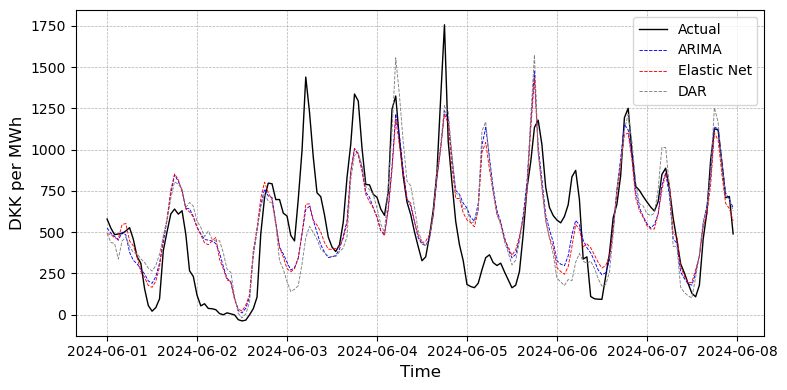

In [5]:
dataset_date = [datasets[hour]['DATE'] for hour in range(24)]

datasets_dates = []

n_days = min(len(datasets[hour]) for hour in range(24))

combined_predictions = []

for day in range(n_days):
    for hour in range(24):
        datasets_dates.append(dataset_date[hour][day])

time = np.array(datasets_dates[-14712:])

df = pd.DataFrame({
    'Time': time,
    'ARIMA': data_baseline['Model_3'],
    'LEAR': data_ml['Predictions'],
    'DARMA': data_darma['Model_1'],
    'Actual': data_baseline['Actual'],
})

df['Time'] = pd.to_datetime(df['Time'])
df = df.set_index('Time')

# If date is 2023-01-01 and next 7 days plot
df = df.loc['2024-06-1':'2024-06-7']

plt.figure(figsize=(8, 4))
plt.plot(df.index, df['Actual'], label='Actual',  color='black', linewidth=1)
plt.plot(df.index, df['ARIMA'], label='ARIMA',  color='blue', linewidth=0.65, linestyle='--')
plt.plot(df.index, df['LEAR'], label='Elastic Net',  color='red', linewidth=0.65, linestyle='--')
plt.plot(df.index, df['DARMA'], label='DAR',  color='grey', linewidth=0.65, linestyle='--')

plt.xlabel('Time', fontsize=12)
plt.ylabel('DKK per MWh', fontsize=12)

plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()
